# Data Collection:
Starting with Data Collection: Which requires to extract around 20,000 questions using StackExchange API.
The Cell below includes functions for:
1. Fetch questions with [nlp] tag from stack overflow.
2. Retrieve answers for each question.
3. Extract accepted answers
4. Function extract necessary field from api response.

In [ ]:
import requests # For API calls (HTTP: requests and response)
import time     # For sleep time
import pandas as pd

# To get 10,000 quota per day
api_key = 'rl_am3NuX7foAUynH13Fqp2QYFcD'

# Function to fetch stack overflow question data
def fetch_stackoverflow_data(tag, page=1, pagesize=100, fromdate=None, todate=None):
    # stack exchange api endpoint to retrieve questions
    url = "https://api.stackexchange.com/2.3/questions"

    parameter = {
        "order": "asc", # Set to descending to get newest response first
        "sort": "creation", # The sorting will be according to post creating (sort by date)
        "tagged": tag, # Tag to search in stack exchange
        "site": "stackoverflow", # Our target website
        "page": page, # Specifies page from where data to be extracted
        "pagesize": pagesize, # Provides number of response per page
        # "access_token": "d7tgnfEEn0paNm9(qlSQAA))",
        "filter": "!9_bDE(fI5", # Will return full body of question
        "key": api_key
    }

    # Including fromdate & todate to extract 20,000 data.
    # As stack overflow only allowing 11,800 data per quesry.
    # Storing fromdate & todate in timestamp format
    if fromdate:
      parameter["fromdate"] = int(fromdate.timestamp())
    if todate:
      parameter["todate"] = int(todate.timestamp())


    try:
        # Making api call
        response = requests.get(url, params=parameter)
        response.raise_for_status() # Give http stauts 200, 400, 500 etc.
        # Storing JSON format response to "data"
        data = response.json()

        # Accessing "items" and "has_more" received from json file "data".
        # Items contains actual questions from SO & has_more give boolean value
        # whether there is still more data or not.
        has_more = data.get("has_more", False)
        # Printing current page and boolean value.
        print(f"Page: {page}: has more = {has_more}")
        return data["items"], has_more

    except requests.exceptions.RequestException as e:
        print(f"Error while fetching data: {e}")
        # Checking responses to check status of API
        print(f"Response status code: {response.status_code if 'response' in locals() else 'N/A'}")
        # print(f"Response text: {response.text if 'response' in locals() else 'N/A'}")

        return None, False

# Extract answers using question ID:
def fetch_answers(question_id):

    url = f"https://api.stackexchange.com/2.3/questions/{question_id}/answers"
    params = {
        "order": "asc",
        "sort": "creation",
        "site": "stackoverflow",
        "filter": "!9_bDE(fI5",
        # "access_token": "d7tgnfEEn0paNm9(qlSQAA))",
        "key": api_key
    }

    response = requests.get(url, params=params)
    response.raise_for_status()
    return response.json().get("items", [])

# Extracting accepted answer's body
def fetch_answer_by_id(answer_id):
    # Used for debugging to avoiding wrong format
    if not answer_id or isinstance(answer_id, tuple):
      return ""

    url = f"https://api.stackexchange.com/2.3/answers/{answer_id}"
    params = {
        "order": "asc",
        "sort": "activity",
        "site": "stackoverflow",
        "filter": "!9_bDE(fI5",
        # "access_token": "d7tgnfEEn0paNm9(qlSQAA))",
        "key": api_key
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        items = response.json().get("items", [])
        # Will return answer body else empty string
        return items[0]["body"] if items else ""

    except Exception as e:
        print(f"Failed to fetch accepted answer body: {e}")
        return ""


# Extract Relevant information from question
def extract_question_data(question, answers):
    # Extract important field from question (API response) storing it into var
    try:
        title = question.get("title", "")
        body = question.get("body", "")
        tags = question.get("tags", [])
        accepted_answer_id = question.get("accepted_answer_id", None),
        creation_date = question.get("creation_date", 0)
        question_id = question.get("question_id", 0)

        # Fetch accepted answer body if present
        # Use fetch_answer_by_id function which will return accepted answer body
        accepted_answer_body = fetch_answer_by_id(accepted_answer_id) if accepted_answer_id else ""


        # Process and extract relevant information from each answer in the list
        processed_answers = []
        for answer in answers:
          answer_data = {
              "answer_body": answer.get("body", "")
          }
          processed_answers.append(answer_data)

        return {
            "title": title,
            "body": body,
            "tags": tags,
            "accepted_answer_id": accepted_answer_id,
            "answers": processed_answers,
            "creation_date": creation_date,
            "question_id": question_id,
            "accepted_answer_body": accepted_answer_body

        }
    except AttributeError as e:
        print(f"Error extracting question data: {e}")
        return {}



In [ ]:
# Execution
from datetime import datetime, timedelta
# Defined tag and pagesize (Won't change in code)
tag = "nlp"
pagesize = 100 # Number of questions per page

# Will use this list to store block of times: e.g. start_date - end_date
date_ranges = []

# To count questions retrieved
items_count = 0
save_interval = 1000 # Save data at every interval
output_file = "stackoverflow_nlp_data.csv"

all_questions_data = []

# Creating date ranges: 90 day blocks
# start_date = datetime(2008, 1, 1) # Stack overflow created at 15th Sep 2008 (Still maintaining safe margin.)
# Retrieved 3,000 got error: Starting with 2011-12-16 date
# Retrieved other 7,000 & got error: 400 bad request due to locked answer or deleted : Now, start with 2019-03-17
# Extracted more 11,000: Now, start with 2022-02-13
start_date = datetime(2022, 2, 13)
end_date = datetime.now()
# Retrieving data in 90 days chunks to maintain API limit
chunk_size = 90

# keeping looping until today's date.
while start_date < end_date:
    # Adding 90 days to start date
    next_date = start_date + timedelta(days=chunk_size)
    # Appending list with tuple of starting date to next date (means 3 months range)
    date_ranges.append((start_date, next_date))
    # Updating start date to the after 3 months
    start_date = next_date

# Now, I have date ranges for 90 days interval

for date_from, date_to in date_ranges:
    print(f"Fetching data from {date_from.date()} to {date_to.date()}")
    page = 1
    has_more = True

    # While there is a next page it will keep running.
    while has_more:
        # Execution of function fetch_stackoverflow_data
        questions, has_more = fetch_stackoverflow_data(tag, page, pagesize, date_from, date_to)
        # If got data from function
        if questions:
          # Iterating through list of questions
          for question in questions:

            try:
              # Question ID and Answer ID to get body of both
              qid = question.get("question_id")
              accepted_id = question.get("accepted_answer_id")
              # Fetch answers using question id inside URL
              answers = fetch_answers(qid)
              # Printing to track
              print(f"Question ID: {qid}, Number of Answers: {len(answers)}")
              # Store answers
              question["answers"] = answers
              # Getting accepted answer body
              if accepted_id:
                # Extracting accepted answer body using accepted answer id and URL
                accepted_answer = fetch_answer_by_id(accepted_id)
                question["accepted_answer_body"] = accepted_answer if accepted_id else ""
              else:
                question["accepted_answer_body"] = ""

              # Execution of function: extract_question_data
              question_data = extract_question_data(question, answers)
              if question_data:
                  # Appending single row and incrementing item number
                  all_questions_data.append(question_data)
                  items_count += 1 # Increment the item counter

            except (AttributeError, KeyError) as e:
              print(f"Error extracting question data: {e}")

            time.sleep(0.1)
            # Checkpointing (Insert this code block)
            if items_count % save_interval == 0:
                df = pd.DataFrame(all_questions_data)
                # converting creation date from delta to readable format
                df["creation_date"] = pd.to_datetime(df["creation_date"], unit='s')
                df.to_csv(output_file, index=False)
                print(f"Saved data to {output_file} at {items_count} questions")

          # Debugging:
          # Incrmenting page
          page += 1
          time.sleep(1.5)

        else:
            print("No more questions to fetch.")
            break

if all_questions_data:
    df = pd.DataFrame(all_questions_data)
    df["creation_date"] = pd.to_datetime(df["creation_date"], unit='s')
    df.to_csv(output_file, index=False)
    print(f"Saved final data to {output_file} ({len(all_questions_data)} questions)")

Fetching data from 2022-02-13 to 2022-05-14
Page: 1: has more = True
Question ID: 71099545, Number of Answers: 1
Question ID: 71099563, Number of Answers: 1
Question ID: 71100013, Number of Answers: 1
Question ID: 71100094, Number of Answers: 0
Question ID: 71101966, Number of Answers: 1
Question ID: 71103188, Number of Answers: 1
Question ID: 71104871, Number of Answers: 0
Question ID: 71112058, Number of Answers: 3
Question ID: 71113363, Number of Answers: 2
Question ID: 71113891, Number of Answers: 2
Question ID: 71116468, Number of Answers: 0
Question ID: 71117138, Number of Answers: 2
Question ID: 71121233, Number of Answers: 2
Question ID: 71124175, Number of Answers: 0
Question ID: 71135198, Number of Answers: 0
Question ID: 71137038, Number of Answers: 0
Question ID: 71138775, Number of Answers: 2
Question ID: 71139924, Number of Answers: 0
Question ID: 71140150, Number of Answers: 0
Question ID: 71140416, Number of Answers: 1
Question ID: 71143240, Number of Answers: 1
Questio

##### Purpose of below Cell

The previous method was unable to  retrieve accepted answers along with the questions. To solve this issue, the following cell is implemented to :separately extract accepted answers using the corresponding question and answer IDs.

- Extracting the accepted answer body (if available) using `accepted_answer_id`.
- Merging the retrieved accepted answer body back into the collected dataset.


In [ ]:
import pandas as pd
import requests
import time
# Library for progress tracking
# Provides well structured progress.
from tqdm import tqdm

# Loading previously scraped data set with some missing fields (columns values)
df = pd.read_csv("/content/SO_NLP.csv")

# Normalizes accepted_answer_id (from tuple to int)
df['accepted_answer_id'] = df['accepted_answer_id'].apply(lambda x: eval(x)[0] if isinstance(x, str) and x.startswith('(') else x)
df['accepted_answer_id'] = pd.to_numeric(df['accepted_answer_id'], errors='coerce')

# Finding missing accepted answer bodies
# Retrives accepted_answer_id into missing_ids
# Create a clean list of accepted answer IDs where the answer body is missing
# Only fetch answers that exists but haven't retrieved yet
missing_ids = df[df['accepted_answer_body'].isna() & df['accepted_answer_id'].notna()]['accepted_answer_id'].astype(int).tolist()
print(f"Missing accepted answers to fetch: {len(missing_ids)}")

# Function to fetch answers from StackExchange API
def fetch_answers(answer_ids):
    ids = ';'.join(map(str, answer_ids))
    url = f"https://api.stackexchange.com/2.3/answers/{ids}"
    params = {
        'order': 'desc',
        'sort': 'activity',
        'site': 'stackoverflow',
        'filter': 'withbody'
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json().get("items", [])
    else:
        print(f"Error: {response.status_code}, sleeping and retrying...")
        time.sleep(5)
        return []

# Fetch in batches
# This time using batches to extract answers
batch_size = 100
accepted_data = []

# Loop through all missing accepted answer IDs in batches,
# Fetching their body and saving into a list
for i in tqdm(range(0, len(missing_ids), batch_size)):
    # Every 100 id in 'batch'
    batch = missing_ids[i:i+batch_size]
    items = fetch_answers(batch) # API call
    for ans in items:
        # Append dictionaries to the list
        accepted_data.append({
            'accepted_answer_id': ans['answer_id'],
            'accepted_answer_body': ans['body']
        })
    # To respect api rate limits
    time.sleep(0.5)

# Creating new dataframe with accepted answers
acc_df = pd.DataFrame(accepted_data)
print(f"Fetched {len(acc_df)} accepted answers")

# Save this for merging later
acc_df.to_csv("accepted_answers_fetched.csv", index=False)
print("Saved to 'accepted_answers_fetched.csv'")


Missing accepted answers to fetch: 6834


100%|██████████| 69/69 [00:48<00:00,  1.43it/s]

Fetched 2070 accepted answers
Saved to 'accepted_answers_fetched.csv'


In [ ]:
# Merging old dataset without accepted answer body with new dataset (Has only accepted answer id and accepted answer body)
old_df = pd.read_csv("/content/SO_NLP.csv")
accepted_df = pd.read_csv("accepted_answers_fetched.csv")

# Converting accepted_answer_id to correct format:
# To successfully merge it with using that IDs.
old_df['accepted_answer_id'] = pd.to_numeric(old_df['accepted_answer_id'], errors='coerce')
accepted_df['accepted_answer_id'] = pd.to_numeric(accepted_df['accepted_answer_id'], errors='coerce')

# Merge based on accepted_answer_id
# Creating new columns with suffix '_fetched' (For, analysis)
merged_df = old_df.merge(
    accepted_df,
    how='left',
    on='accepted_answer_id',
    suffixes=('', '_fetched')
)

# Fill missing accepted answer bodies
merged_df['accepted_answer_body'] = merged_df['accepted_answer_body'].fillna(merged_df['accepted_answer_body_fetched'])




In [ ]:
merged_df.head()

,title,body,tags,accepted_answer_id,answers,creation_date,question_id,accepted_answer_body,accepted_answer_body_fetched
0,Natural language date/time parser for .NET?,<p>Does anyone know of a .NET date/time parser...,"['.net', 'datetime', 'nlp']",631134.0,"[{'answer_body': '<p>I\'m not aware of one, bu...",2008-08-22 22:45:10,23689,<p>We developed exactly what you are looking f...,<p>We developed exactly what you are looking f...
1,What&#39;s a good natural language library to ...,<p>I'm looking for an existing library to summ...,"['language-agnostic', 'nlp']",NaN,[{'answer_body': '<p>Your getting into really ...,2008-08-24 20:57:33,25332,NaN,NaN
2,Vista speech recognition in multiple languages,"<p>my primary language is spanish, but I use a...","['windows-vista', 'nlp', 'speech-recognition',...",36684.0,[{'answer_body': '<p>Citation from Vista <a hr...,2008-08-31 01:08:48,36533,NaN,NaN
3,How do you implement a &quot;Did you mean&quot;?,<blockquote>\n <p><strong>Possible Duplicate:...,['nlp'],41448.0,"[{'answer_body': ""<p>Soundex is good for phone...",2008-09-03 10:36:13,41424,NaN,NaN
4,How to implement a &quot;related&quot; degree ...,<p>I was going to Ask a Question earlier today...,"['algorithm', 'machine-learning', 'indexing', ...",42532.0,"[{'answer_body': ""<p>One such way to implement...",2008-09-03 20:21:04,42489,NaN,NaN


In [ ]:
merged_df.drop(columns=['accepted_answer_body_fetched'], inplace=True)

# Saving final dataset with required fields
merged_df.to_csv("stackoverflow_data.csv", index=False)

# Preprocessing:

In [ ]:
import pandas as pd

df_raw = pd.read_csv("/content/stackoverflow_data.csv")

In [ ]:
df = df_raw.copy()
df.head(3)

,title,body,tags,accepted_answer_id,answers,creation_date,question_id,accepted_answer_body
0,Natural language date/time parser for .NET?,<p>Does anyone know of a .NET date/time parser...,"['.net', 'datetime', 'nlp']",631134.0,"[{'answer_body': '<p>I\'m not aware of one, bu...",2008-08-22 22:45:10,23689,NaN
1,What&#39;s a good natural language library to ...,<p>I'm looking for an existing library to summ...,"['language-agnostic', 'nlp']",NaN,[{'answer_body': '<p>Your getting into really ...,2008-08-24 20:57:33,25332,NaN
2,Vista speech recognition in multiple languages,"<p>my primary language is spanish, but I use a...","['windows-vista', 'nlp', 'speech-recognition',...",36684.0,[{'answer_body': '<p>Citation from Vista <a hr...,2008-08-31 01:08:48,36533,NaN


Starting with storing only necessary columns.
Then applying at least four preprocessing:
1. Lowercase: apply lowercase to every columns. This will ensures uniformity and will avoid issues of word sensitivity.
2. HTML Removal: Remove html tags such as < p>, < br>, and other formatting tags. It is necessary to get only raw content.
3. Remove URL: External links not necessary right now. Additionally, It can introduce noise in data with URL meanings after tokenization.
4. Punctuation: Removing punctuation such as (',' , '.', ';')
5. Tokenization: Tokenize text from Columns It will be helpful for model training.
6. StopWord : Remove stopword (e.g. 'the', 'is', 'in') from the text data

These steps are helpful to get clean, standardized, and ready for NLP tasks like: classification or clustering.

In [ ]:
df = df[["title", "body", "tags", "accepted_answer_body", "answers"]]
# Reseting index numbers
df = df.reset_index(drop=True)
df.head()

,title,body,tags,accepted_answer_body,answers
0,Natural language date/time parser for .NET?,<p>Does anyone know of a .NET date/time parser...,"['.net', 'datetime', 'nlp']",NaN,"[{'answer_body': '<p>I\'m not aware of one, bu..."
1,What&#39;s a good natural language library to ...,<p>I'm looking for an existing library to summ...,"['language-agnostic', 'nlp']",NaN,[{'answer_body': '<p>Your getting into really ...
2,Vista speech recognition in multiple languages,"<p>my primary language is spanish, but I use a...","['windows-vista', 'nlp', 'speech-recognition',...",NaN,[{'answer_body': '<p>Citation from Vista <a hr...
3,How do you implement a &quot;Did you mean&quot;?,<blockquote>\n <p><strong>Possible Duplicate:...,['nlp'],NaN,"[{'answer_body': ""<p>Soundex is good for phone..."
4,How to implement a &quot;related&quot; degree ...,<p>I was going to Ask a Question earlier today...,"['algorithm', 'machine-learning', 'indexing', ...",NaN,"[{'answer_body': ""<p>One such way to implement..."


In [ ]:
# lowercasing columns
df['title'] = df['title'].str.lower()
df['body'] = df['body'].str.lower()
df['accepted_answer_body'] = df['accepted_answer_body'].str.lower()
df['answers'] = df['answers'].str.lower()

In [ ]:
# Now, remove html tags from text.

# Will remove html tags using regular expression
import re

def remove_html(text):
    if not isinstance(text, str):
        return ""
    return re.sub(r'<[^>]+>', ' ', text)



In [ ]:
# Apply function to my columns
df["title"] = df["title"].apply(remove_html)
df["body"] = df["body"].apply(remove_html)
df["accepted_answer_body"] = df["accepted_answer_body"].apply(remove_html)
df["answers"] = df["answers"].apply(remove_html)

In [ ]:
# Defining function to remove URLs.
# URL is not necessary in text categorisation task
def remove_urls(text):
    if not isinstance(text, str):
        return ""
    return re.sub(r'http\S+|www\.\S+', '', text)

In [ ]:
# Apply on all columns
df["title"] = df["title"].apply(remove_urls)
df["body"] = df["body"].apply(remove_urls)
df["accepted_answer_body"] = df["accepted_answer_body"].apply(remove_urls)
df["answers"] = df["answers"].apply(remove_urls)

In [ ]:
# function for removing punctuation
import string

def remove_punctuation(text):
    if not isinstance(text, str):
        return ""
    return text.translate(str.maketrans('', '', string.punctuation))

In [ ]:
df["title"] = df["title"].apply(remove_punctuation)
df["body"] = df["body"].apply(remove_punctuation)
df["accepted_answer_body"] = df["accepted_answer_body"].apply(remove_punctuation)
df["answers"] = df["answers"].apply(remove_punctuation)

In [ ]:
# Tokenizing words using nltk
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')

def tokenize_text(text):
    if not isinstance(text, str):
        return []
    return word_tokenize(text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
df["title"] = df["title"].apply(tokenize_text)
df["body"] = df["body"].apply(tokenize_text)
df["accepted_answer_body"] = df["accepted_answer_body"].apply(tokenize_text)
df["answers"] = df["answers"].apply(tokenize_text)

In [ ]:
# removing stopwords from data
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df["title"] = df["title"].apply(remove_stopwords)
df["body"] = df["body"].apply(remove_stopwords)
df["accepted_answer_body"] = df["accepted_answer_body"].apply(remove_stopwords)
df["answers"] = df["answers"].apply(remove_stopwords)

In [ ]:
print(df["title"][0])
print(df["body"][0])
df.head()

['natural', 'language', 'datetime', 'parser', 'net']
['anyone', 'know', 'net', 'datetime', 'parser', 'similar', 'chronic', 'ruby', 'handles', 'stuff', 'like', 'tomorrow', '3pm', 'next', 'thursday', 'note', 'write', 'ruby', 'know', 'chronic', 'project', 'must', 'use', 'net']


,title,body,tags,accepted_answer_body,answers
0,"[natural, language, datetime, parser, net]","[anyone, know, net, datetime, parser, similar,...","['.net', 'datetime', 'nlp']",[],"[answerbody, im, aware, one, sounded, like, co..."
1,"[what39s, good, natural, language, library, us...","[im, looking, existing, library, summarize, pa...","['language-agnostic', 'nlp']",[],"[answerbody, getting, really, far, ai, type, d..."
2,"[vista, speech, recognition, multiple, languages]","[primary, language, spanish, use, software, en...","['windows-vista', 'nlp', 'speech-recognition',...",[],"[answerbody, citation, vista, speech, recognit..."
3,"[implement, quotdid, meanquot]","[possible, duplicate, google, “, mean, ”, algo...",['nlp'],[],"[answerbody, soundex, good, phonetic, matches,..."
4,"[implement, quotrelatedquot, degree, measure, ...","[going, ask, question, earlier, today, present...","['algorithm', 'machine-learning', 'indexing', ...",[],"[answerbody, one, way, implement, algorithm, w..."


In [ ]:
# Join text back to string for Visualization
df["title"] = df["title"].apply(lambda x: " ".join(x))
df["body"] = df["body"].apply(lambda x: " ".join(x))
df["accepted_answer_body"] = df["accepted_answer_body"].apply(lambda x: " ".join(x))
df["answers"] = df["answers"].apply(lambda x: " ".join(x))

# Visualization:
Let's visualize with WordCloud to avoid dominating words such as stop words

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
text_data = " ".join(df["title"].dropna().astype(str).tolist())
text_data_q_body = " ".join(df["body"].dropna().astype(str).tolist())

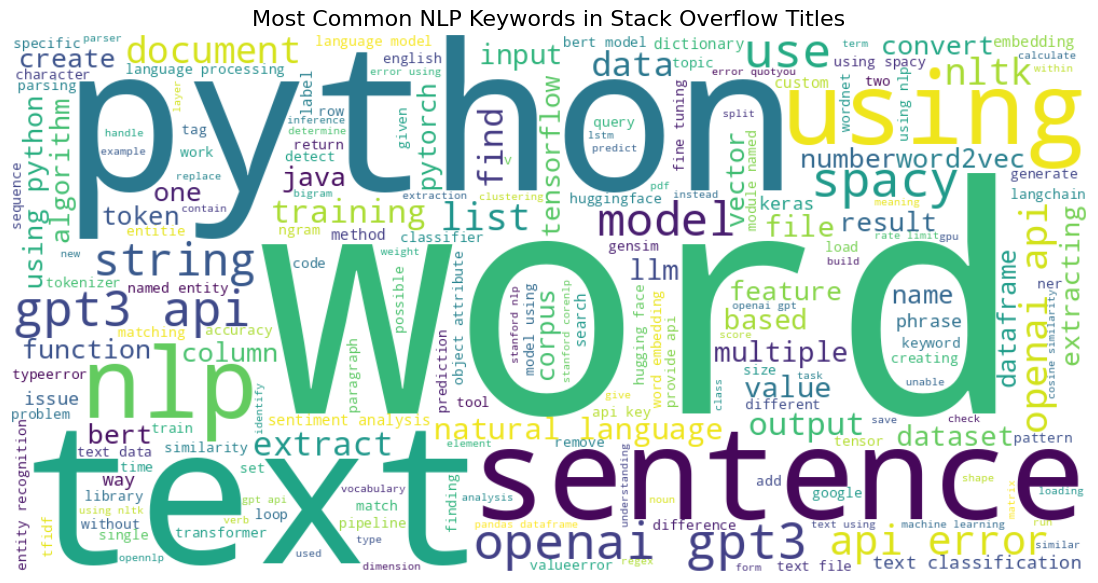

In [ ]:
wordcloud = WordCloud(

    width=1000,
    height=500,
    background_color="white",
    colormap="viridis",
    max_words=200
).generate(text_data)

# Display
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common NLP Keywords in Stack Overflow Titles", fontsize=16)
plt.show()


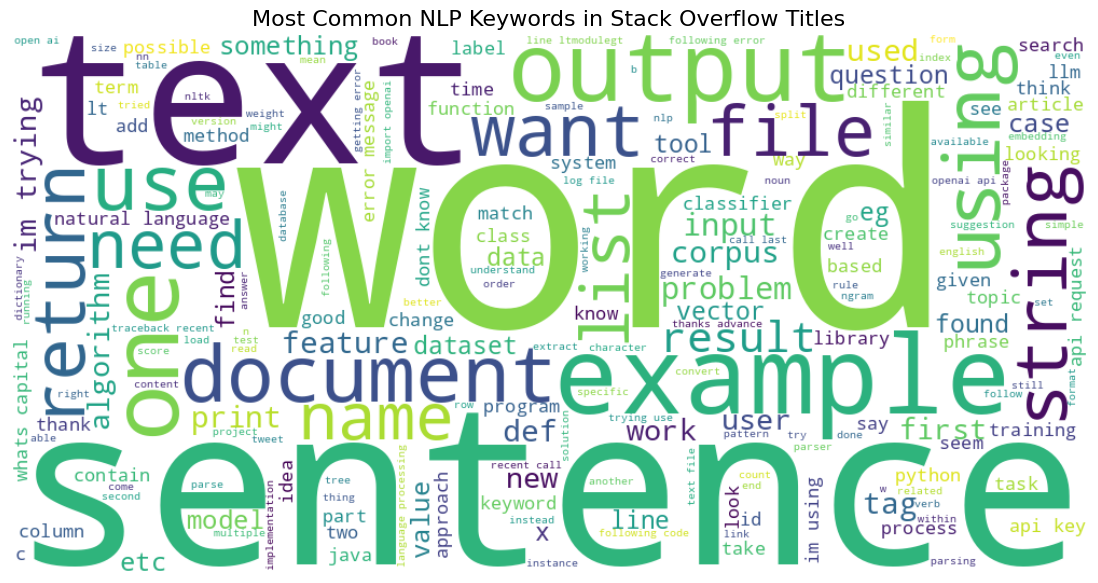

In [ ]:
wordcloud = WordCloud(

    width=1000,
    height=500,
    background_color="white",
    colormap="viridis",
    max_words=200
).generate(text_data_q_body)

# Display
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common NLP Keywords in Stack Overflow Titles", fontsize=16)
plt.show()


From above output, It is clear there are only relevant information and related to Natural Language tasks and solution seeking.
Also, There isn't any dominating stop words in title.

# Categorization:
#### Categorizing using rule based categorization.
If certain words belong to these types of task then categorize into defined category

In [ ]:
# Defining new column named "category"
# Assign every value as "Uncategorized"
df["category"] = "Uncategorized"

# Part 1: Implementation issues (how to / how)
# Categorizing question with keywords such as how to , how etc.
# This type of keyword gives us insight for issues faced by developers for implementation
def is_implementation_issue(text):
    if not isinstance(text, str):
        return False
    text = text.lower()
    return "how" in text or "how to" in text or text.startswith("how ")

df.loc[df["category"] == "Uncategorized", "category"] = df[df["category"] == "Uncategorized"]["title"].apply(
    lambda x: "Implementation Issue" if is_implementation_issue(x) else "Uncategorized"
)




In [ ]:
# Part 2: Task-Based categories
# Catorgorizes data with tasks such as similarity, lemmatization etc.
# Defined keywords for task present in data.
task_keywords = {
    "Text Similarity": ["similarity", "semantic similarity"],
    "Tokenization": ["tokenize", "tokenization", "tokens"],
    "Stemming/Lemmatization": ["stemming", "lemmatization", "lemmatize", "stemmer"],
    "Sentiment Analysis": ["sentiment"],
    "Language Detection": ["language detection", "detect language", "language identification"],
    "Summarization": ["summarization", "summarize"],
    "Text Classification": ["classification", "text classification"],
    "Error or Debugging": ["error", "exception", "not working", "fail", "bug", "traceback", "crash"],
    "Optimization or Best Practice": ["best way", "optimize", "performance", "efficient", "slow", "speed"],
    "Conceptual Understanding": ["what is", "difference between", "explain", "mean", "understand"],
    "Data Handling or Preparation": ["dataset", "data", "corpus", "load data", "text file", "dataframe"]
}

# Loop will iterate through task_keywords and store it in category and keywords
# for each keyword, it is matched whole words with regex.
for category, keywords in task_keywords.items():
    pattern = "|".join([fr"\b{kw}\b" for kw in keywords]) # regex pattern for match any keyword
    mask = df["category"] == "Uncategorized"  # Only apply to uncategorized rows
    df.loc[mask & df["title"].str.lower().str.contains(pattern, regex=True), "category"] = category





In [ ]:
# Part 3: Library-Specific categories
library_keywords = {
    "Spacy": ["spacy"],
    "NLTK": ["nltk"],
    "Transformers": ["transformers", "huggingface"],
    "Gensim": ["gensim"],
    "LDA/Topic Modeling": ["lda", "topic modeling"],
    "Word2Vec / FastText": ["word2vec", "fasttext"],
}

# Loop over the libraries and keywords to categorize questions
# For each libraray, Search for matching keywords in the title and assign it to the correct category
for category, keywords in library_keywords.items():
    pattern = "|".join([fr"\b{kw}\b" for kw in keywords])
    mask = df["category"] == "Uncategorized"
    df.loc[mask & df["title"].str.lower().str.contains(pattern, regex=True), "category"] = category

In [ ]:
# Count categorized rows
category_counts = df["category"].value_counts()
print("Categorized Post Count:\n", category_counts)

# # Save categorized dataset
# df.to_csv("categorized_stackoverflow_nlp.csv", index=False)

Categorized Post Count:
 category
Uncategorized                    13702
Error or Debugging                1722
Data Handling or Preparation      1495
Spacy                              817
NLTK                               459
Tokenization                       403
Text Classification                393
Text Similarity                    379
Transformers                       308
Word2Vec / FastText                275
Sentiment Analysis                 259
Optimization or Best Practice      245
Gensim                             185
Stemming/Lemmatization             165
Conceptual Understanding            82
Implementation Issue                81
LDA/Topic Modeling                  74
Summarization                       70
Language Detection                  30
Name: count, dtype: int64


In [ ]:
df.head()

,title,body,tags,accepted_answer_body,answers,category
0,natural language datetime parser net,anyone know net datetime parser similar chroni...,"['.net', 'datetime', 'nlp']",,answerbody im aware one sounded like cool prob...,Uncategorized
1,what39s good natural language library use para...,im looking existing library summarize paraphra...,"['language-agnostic', 'nlp']",,answerbody getting really far ai type domain d...,Uncategorized
2,vista speech recognition multiple languages,primary language spanish use software english ...,"['windows-vista', 'nlp', 'speech-recognition',...",,answerbody citation vista speech recognition b...,Uncategorized
3,implement quotdid meanquot,possible duplicate google “ mean ” algorithm w...,['nlp'],,answerbody soundex good phonetic matches works...,Uncategorized
4,implement quotrelatedquot degree measure algor...,going ask question earlier today presented sur...,"['algorithm', 'machine-learning', 'indexing', ...",,answerbody one way implement algorithm would i...,Uncategorized


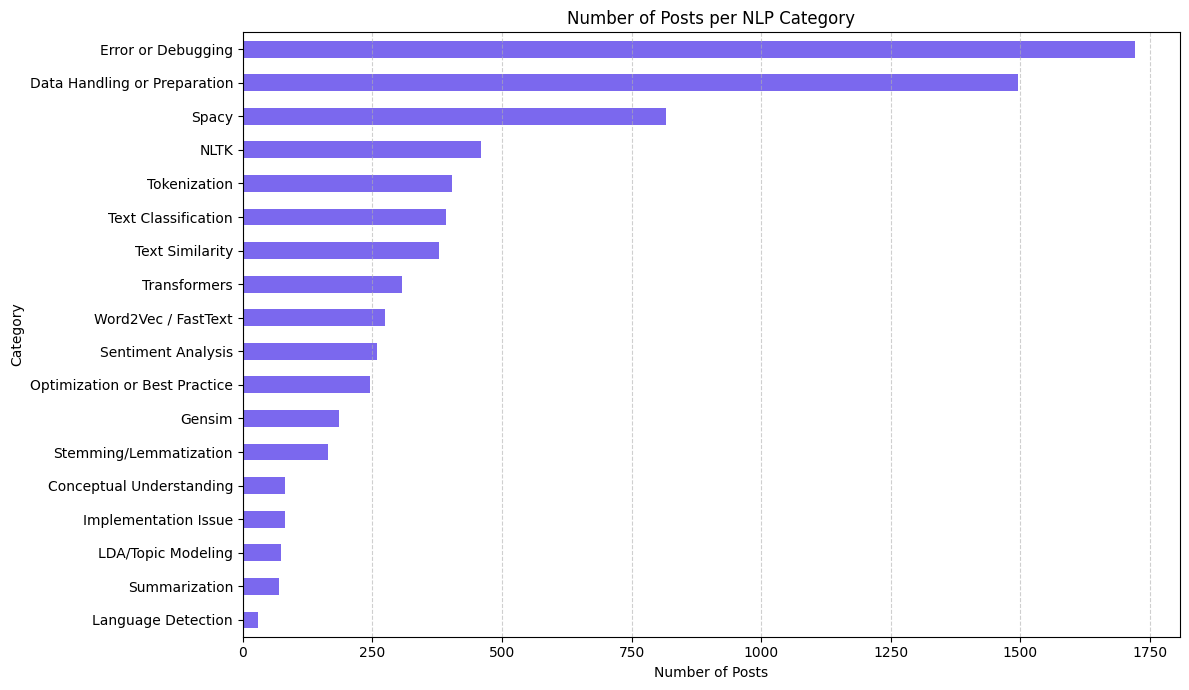

In [ ]:
# Visualizing category

# Exclude Uncategorized posts
df_wo_uncat = df[df["category"] != "Uncategorized"]

# Count posts per category
category_counts = df_wo_uncat["category"].value_counts().sort_values(ascending=True)

# Plot
plt.figure(figsize=(12, 7))
category_counts.plot(kind='barh', color='mediumslateblue')
plt.title("Number of Posts per NLP Category")
plt.xlabel("Number of Posts")
plt.ylabel("Category")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
